In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from os.path import join
import os
import random
from functools import partial
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate
from keras.optimizers import Nadam
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.backend import binary_crossentropy

import tensorflow as tf
import ntpath
K.clear_session()
K.set_image_dim_ordering('tf')

print(K.image_data_format())
smooth = 1e-12
num_examples = 0

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


channels_last


In [2]:
import glob
image_size = 512
def load_files():
    global image_size
    global num_examples
    mask_images=[]
    ori_images = []
    mask_path="/home/ubuntu/Downloads/train_masks/"
    og_path="/home/ubuntu/Downloads/train_hq/"
    overlay_path = "/home/ubuntu/Downloads/train_hq/*"
    overlay = glob.glob(overlay_path)
    print("Loading masks")
    for fl in overlay:
        basenm = ntpath.basename(fl)
        mask_img = mask_path+basenm
        train_image = cv2.imread(mask_img)
        #Supervisely gives 3 images in out and we need the mask only
        train_image = cv2.resize(train_image, (image_size, image_size))
        mask_images.append(train_image)
    print("loading original")
    for fl in overlay:
        basenm = ntpath.basename(fl)
        og_im = og_path+basenm
        orig_images = cv2.imread(og_im)
        orig_images = cv2.resize(orig_images, (image_size, image_size))
        ori_images.append(orig_images)
    masked = np.array(mask_images)
    origi = np.array(ori_images)
    num_examples = masked.shape[0]
    return masked, origi

masks, origi = load_files()

Loading masks


error: /io/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215) ssize.width > 0 && ssize.height > 0 in function resize


In [3]:
def get_unet(size, n_cls):
    inputs = Input((size, size, 3))
    
    conv1 = BatchNormalization()(inputs)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)
    conv6 = Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)
    conv7 = Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)
    conv8 = Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)
    conv9 = Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

In [4]:

def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)



In [5]:
class BatchGenerator:
    
    def __init__(self, size, n_cls, batch_size):
        self.size = size
        self.n_cls = n_cls
        self.batch_size = batch_size
        self.i = 0
    
    def get_batch(self):
        global masks
        global origi
        while True:
            orig_batch = np.zeros((self.batch_size, self.size, self.size, 3))
            gt_batch = np.zeros((self.batch_size, self.size, self.size, 3))
            perm = np.arange(num_examples)
            np.random.shuffle(perm)
            masks = [masks[j] for j in perm]
            origi = [origi[j] for j in perm]
            for i in range(self.batch_size):
                orig_batch[i] = origi[i]
                gt_batch[i] = masks[i]
            yield orig_batch, gt_batch

In [6]:
from keras.callbacks import TensorBoard
from time import time

train_batch_generator = BatchGenerator( image_size, 1, 1)
size = image_size
n_cls = 1
model = get_unet(size, n_cls)
model.compile(optimizer=Nadam(lr=1e-3), loss=jaccard_coef_loss, metrics=['binary_crossentropy', jaccard_coef_int])
tensorboard = TensorBoard(log_dir="logs/", batch_size=4,write_graph=True)

model.fit_generator(train_batch_generator.get_batch(),verbose=2,steps_per_epoch=num_examples,epochs=20, callbacks=[tensorboard])

Epoch 1/20
 - 3423s - loss: -5.1337e+00 - binary_crossentropy: -1.2443e+03 - jaccard_coef_int: 212.7240
Epoch 2/20
 - 3399s - loss: -5.2979e+00 - binary_crossentropy: -1.3466e+03 - jaccard_coef_int: 219.7007
Epoch 3/20
 - 3398s - loss: -5.3196e+00 - binary_crossentropy: -1.3467e+03 - jaccard_coef_int: 221.2175
Epoch 4/20
 - 3398s - loss: -5.3293e+00 - binary_crossentropy: -1.3495e+03 - jaccard_coef_int: 222.1566
Epoch 5/20
 - 3399s - loss: -5.3267e+00 - binary_crossentropy: -1.3438e+03 - jaccard_coef_int: 221.9452
Epoch 6/20
 - 3398s - loss: -5.3372e+00 - binary_crossentropy: -1.3466e+03 - jaccard_coef_int: 222.6363
Epoch 7/20
 - 3398s - loss: -5.3478e+00 - binary_crossentropy: -1.3458e+03 - jaccard_coef_int: 223.4967
Epoch 8/20
 - 3397s - loss: -5.3457e+00 - binary_crossentropy: -1.3460e+03 - jaccard_coef_int: 223.3526
Epoch 9/20
 - 3397s - loss: -5.3516e+00 - binary_crossentropy: -1.3514e+03 - jaccard_coef_int: 224.0005
Epoch 10/20
 - 3398s - loss: -5.3569e+00 - binary_crossentropy: 

In [7]:
from importlib import reload
reload(K)
import h5py
model.save('modelbatchone.h5')

Using TensorFlow backend.


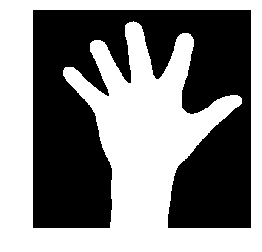

In [13]:
train_image = cv2.imread("train/btrain/14606.png")
shape = train_image.shape
train_image = cv2.resize(train_image, (image_size, image_size))
train_pic = np.array(train_image)
train_pic.shape
image = np.expand_dims(train_pic, axis=0)
mpo=model.predict(image)
#print(mpo)
mpo = mpo.reshape(512,512,3)
plt.axis('off')
plt.imshow(mpo)
#plt.savefig('output.png')
plt.show()

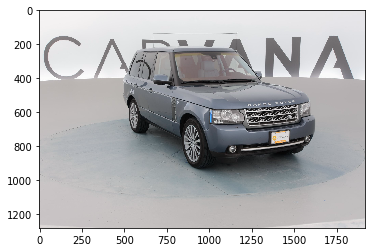

In [3]:
trin =cv2.imread('/home/ubuntu/Downloads/train_hq/fff9b3a5373f_16.jpg')
plt.imshow(trin)
plt.show()

In [4]:
trin.shape

(1280, 1918, 3)